In [37]:
# Import libraries
import pandas as pd
import numpy as np
import ast
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

In [38]:
# Load dataset
df = pd.read_csv('books_1.Best_Books_Ever.csv')
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             52478 non-null  object 
 1   series            23470 non-null  object 
 2   author            52478 non-null  object 
 3   rating            52478 non-null  float64
 4   description       51140 non-null  object 
 5   language          48672 non-null  object 
 6   isbn              52478 non-null  object 
 7   genres            52478 non-null  object 
 8   characters        52478 non-null  object 
 9   bookFormat        51005 non-null  object 
 10  edition           4955 non-null   object 
 11  pages             50131 non-null  object 
 12  publisher         48782 non-null  object 
 13  publishDate       51598 non-null  object 
 14  firstPublishDate  31152 non-null  object 
 15  awards            52478 non-null  object 
 16  numRatings        52478 non-null  int64 

(None,
                                        title                 series  \
 0                           The Hunger Games    The Hunger Games #1   
 1  Harry Potter and the Order of the Phoenix        Harry Potter #5   
 2                      To Kill a Mockingbird  To Kill a Mockingbird   
 3                        Pride and Prejudice                    NaN   
 4                                   Twilight   The Twilight Saga #1   
 
                                       author  rating  \
 0                            Suzanne Collins    4.33   
 1  J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
 2                                 Harper Lee    4.28   
 3  Jane Austen, Anna Quindlen (Introduction)    4.26   
 4                            Stephenie Meyer    3.60   
 
                                          description language         isbn  \
 0  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...  English  9.78044E+12   
 1  There is a door at the end of a silent corrido...  En

In [39]:
df.describe()

,rating,numRatings,likedPercent,bbeScore,bbeVotes
count,52478.000000,5.247800e+04,51856.000000,5.247800e+04,52478.000000
mean,4.021878,1.787865e+04,92.231545,1.984023e+03,22.529003
std,0.367146,1.039448e+05,5.990689,3.515314e+04,369.158541
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.000000
25%,3.820000,3.410000e+02,90.000000,8.400000e+01,1.000000
50%,4.030000,2.307000e+03,94.000000,9.700000e+01,1.000000
75%,4.230000,9.380500e+03,96.000000,1.870000e+02,2.000000
max,5.000000,7.048471e+06,100.000000,2.993816e+06,30516.000000


In [40]:
# Check missing values
missing_values = df.isnull().sum()
missing_values

title                   0
series              29008
author                  0
rating                  0
description          1338
language             3806
isbn                    0
genres                  0
characters              0
bookFormat           1473
edition             47523
pages                2347
publisher            3696
publishDate           880
firstPublishDate    21326
awards                  0
numRatings              0
ratingsByStars          0
likedPercent          622
setting                 0
bbeScore                0
bbeVotes                0
price               14365
dtype: int64

In [41]:
# Drop unnecessary columns
df = df.drop(columns=['series','characters','bookFormat','edition','pages','publisher','publishDate','firstPublishDate','likedPercent','ratingsByStars','setting','awards','bbeScore','bbeVotes','price'])

In [42]:
# Drop duplicates and nulls, use first 10000 rows after dropping
df = df.drop_duplicates(subset=['title', 'author']).head(10000)
df = df.dropna(subset=['title', 'genres', 'author','language','rating', 'numRatings','description'])

In [43]:
df['genres']

0        ['Young Adult', 'Fiction', 'Dystopia', 'Fantas...
1        ['Fantasy', 'Young Adult', 'Fiction', 'Magic',...
2        ['Classics', 'Fiction', 'Historical Fiction', ...
3        ['Classics', 'Fiction', 'Romance', 'Historical...
4        ['Young Adult', 'Fantasy', 'Romance', 'Vampire...
                               ...                        
10000    ['Nonfiction', 'Business', 'Entrepreneurship',...
10001    ['Fantasy', 'Fiction', 'Epic Fantasy', 'High F...
10002    ['Dystopia', 'Young Adult', 'Fantasy', 'Fictio...
10003    ['Young Adult', 'Fantasy', 'Paranormal', 'Magi...
10005    ['Picture Books', 'Childrens', 'Fiction', 'Cla...
Name: genres, Length: 9647, dtype: object

In [44]:
df['author']

0                                  Suzanne Collins
1        J.K. Rowling, Mary GrandPré (Illustrator)
2                                       Harper Lee
3        Jane Austen, Anna Quindlen (Introduction)
4                                  Stephenie Meyer
                           ...                    
10000                               Blake Mycoskie
10001       Michael J. Sullivan (Goodreads Author)
10002             Bella Forrest (Goodreads Author)
10003      Laurie Faria Stolarz (Goodreads Author)
10005                          Virginia Lee Burton
Name: author, Length: 9647, dtype: object

In [45]:
# Clean 'genres'
def clean_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return ' '.join(g.strip().replace(' ', '_') for g in genres if isinstance(g, str))
    except:
        return ''

# Clean 'author'
def clean_author(author_str):
    return author_str.split(',')[0].strip()

# Apply cleaning
df['clean_genres'] = df['genres'].apply(clean_genres)
df['clean_author'] = df['author'].apply(clean_author)
df.reset_index(drop=True, inplace=True)

In [46]:
df['clean_genres']

0       Young_Adult Fiction Dystopia Fantasy Science_F...
1       Fantasy Young_Adult Fiction Magic Childrens Ad...
2       Classics Fiction Historical_Fiction School Lit...
3       Classics Fiction Romance Historical_Fiction Li...
4       Young_Adult Fantasy Romance Vampires Fiction P...
                              ...                        
9642    Nonfiction Business Entrepreneurship Biography...
9643    Fantasy Fiction Epic_Fantasy High_Fantasy Audi...
9644    Dystopia Young_Adult Fantasy Fiction Science_F...
9645    Young_Adult Fantasy Paranormal Magic Witches M...
9646    Picture_Books Childrens Fiction Classics Juven...
Name: clean_genres, Length: 9647, dtype: object

<Axes: ylabel='clean_genres'>

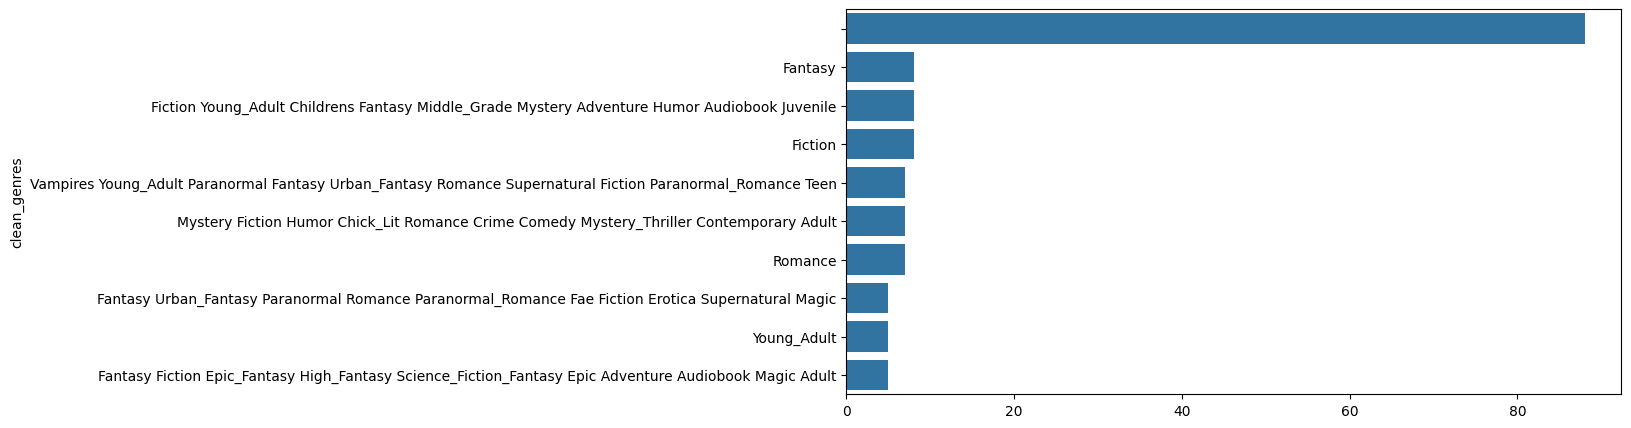

In [47]:
top_10_genre = df['clean_genres'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_genre.values, y=top_10_genre.index)

In [48]:
df['clean_author']

0                               Suzanne Collins
1                                  J.K. Rowling
2                                    Harper Lee
3                                   Jane Austen
4                               Stephenie Meyer
                         ...                   
9642                             Blake Mycoskie
9643     Michael J. Sullivan (Goodreads Author)
9644           Bella Forrest (Goodreads Author)
9645    Laurie Faria Stolarz (Goodreads Author)
9646                        Virginia Lee Burton
Name: clean_author, Length: 9647, dtype: object

<Axes: ylabel='clean_author'>

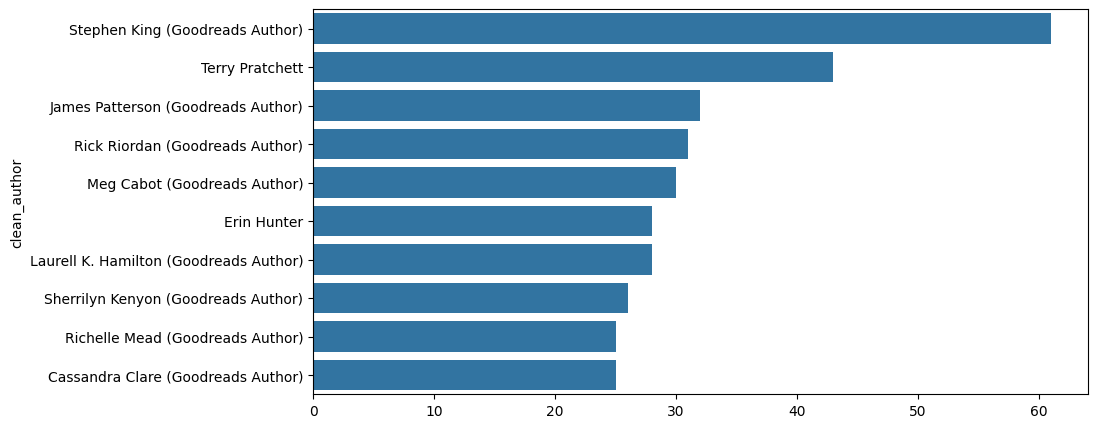

In [49]:
top_10_author = df['clean_author'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_author.values, y=top_10_author.index)

5.0


<Axes: ylabel='rating'>

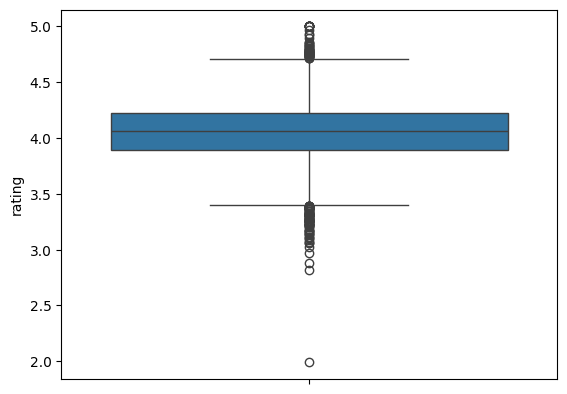

In [50]:
print(df['rating'].max())
sns.boxplot(df['rating'])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9647 entries, 0 to 9646
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         9647 non-null   object 
 1   author        9647 non-null   object 
 2   rating        9647 non-null   float64
 3   description   9647 non-null   object 
 4   language      9647 non-null   object 
 5   isbn          9647 non-null   object 
 6   genres        9647 non-null   object 
 7   numRatings    9647 non-null   int64  
 8   clean_genres  9647 non-null   object 
 9   clean_author  9647 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 753.8+ KB


In [52]:
# Define vectorizers for different features
tfidf_genres = TfidfVectorizer(stop_words='english', max_features=200)
tfidf_author = TfidfVectorizer(max_features=100)
tfidf_title = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)

# Create TF-IDF matrices for each feature
genres_vec = tfidf_genres.fit_transform(df['clean_genres'])
author_vec = tfidf_author.fit_transform(df['clean_author'])
title_vec = tfidf_title.fit_transform(df['title'])

# Combine the matrices with weights
weighted_features = hstack([genres_vec * 3, title_vec * 2, author_vec])

In [53]:
print(weighted_features)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 113792 stored elements and shape (9647, 1300)>
  Coords	Values
  (0, 195)	0.6282790656565915
  (0, 72)	0.3671170761806378
  (0, 56)	1.1675645875012695
  (0, 70)	0.5632017709678709
  (0, 158)	0.898802981951008
  (0, 151)	0.6050268969272496
  (0, 6)	0.7965417562623942
  (0, 177)	1.030874711601888
  (0, 141)	1.4259090675888264
  (0, 3)	1.3732387670520276
  (0, 642)	1.4142135623730951
  (0, 550)	1.4142135623730951
  (1, 195)	0.7415727089092171
  (1, 72)	0.4333170076032928
  (1, 70)	0.6647604317718853
  (1, 6)	0.9401771605003209
  (1, 112)	1.0691858659969184
  (1, 33)	1.1621683742697624
  (1, 21)	0.8875453366858923
  (1, 119)	1.2475463663052375
  (1, 39)	0.8777297728563123
  (1, 159)	1.152455987200254
  (1, 603)	0.9635077287637629
  (1, 886)	0.9635077287637629
  (1, 840)	1.088436243192037
  :	:
  (9645, 72)	0.3945463464142971
  (9645, 70)	0.6052815721383075
  (9645, 151)	0.6502316758144191
  (9645, 177)	1.1078968467086205
  (9645

In [54]:
# SVD tuning
svd_test = TruncatedSVD(n_components=300, random_state=42)
svd_test.fit(weighted_features)

# Find SVD optimal n_components
cumulative_variance = np.cumsum(svd_test.explained_variance_ratio_)

In [55]:
cumulative_variance

array([0.01706835, 0.05812071, 0.09240843, 0.12164327, 0.14918237,
       0.16997172, 0.19039676, 0.20791818, 0.22386014, 0.23701577,
       0.24921933, 0.26062238, 0.27098826, 0.28081293, 0.29024859,
       0.2992749 , 0.30761747, 0.31570861, 0.32343555, 0.33075693,
       0.33799007, 0.34477729, 0.35121654, 0.35758653, 0.36386679,
       0.36997656, 0.37580896, 0.38155532, 0.3871491 , 0.39263281,
       0.39798451, 0.40317619, 0.4082147 , 0.41313821, 0.41804238,
       0.42284969, 0.42759605, 0.43221272, 0.43677809, 0.44110154,
       0.44538176, 0.44955468, 0.45365523, 0.45768466, 0.46168962,
       0.46565733, 0.46954975, 0.47339813, 0.47720619, 0.48093521,
       0.48459438, 0.48818893, 0.49170741, 0.49521696, 0.4987091 ,
       0.50208461, 0.50541467, 0.50873019, 0.51201804, 0.51526118,
       0.51843338, 0.52160211, 0.52470903, 0.52777272, 0.53079247,
       0.53379022, 0.53675087, 0.53968366, 0.54254991, 0.54540316,
       0.54821601, 0.55100157, 0.5537419 , 0.55643786, 0.55911

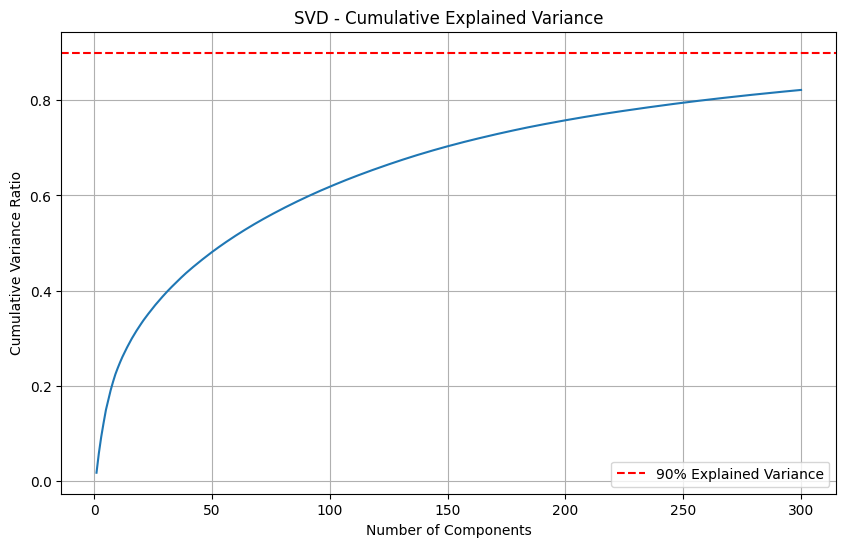

In [56]:
# Plot variance to find elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 301), cumulative_variance)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.title('SVD - Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
svd = TruncatedSVD(n_components=300, random_state=42)
reduced = svd.fit_transform(weighted_features)

In [58]:
print(reduced.shape)
reduced

(9647, 300)


array([[ 1.13392272, -0.33901171,  0.62091332, ..., -0.06760225,
        -0.00366997,  0.06213056],
       [ 1.42840694, -0.18370467,  1.6511409 , ...,  0.1069725 ,
        -0.08867267,  0.09497426],
       [ 0.76549651,  0.94161852,  0.70981455, ...,  0.14921534,
         0.01211711,  0.11421349],
       ...,
       [ 1.54673833, -0.36956528,  0.10309822, ...,  0.00970058,
        -0.01728278,  0.04516317],
       [ 1.83698808, -1.02355016, -0.21613093, ...,  0.03981299,
         0.02668558,  0.01221594],
       [ 0.6060475 ,  0.30157686,  0.63806459, ...,  0.02818424,
         0.02198901,  0.07311788]])

In [59]:
# Find KMeans optimal n_clusters
inertia = []
k_range = range(10, 201, 10)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(reduced)
    inertia.append(kmeans_test.inertia_)
    print(f"Completed k={k}")

Completed k=10
Completed k=20
Completed k=30
Completed k=40
Completed k=50
Completed k=60
Completed k=70
Completed k=80
Completed k=90
Completed k=100
Completed k=110
Completed k=120
Completed k=130
Completed k=140
Completed k=150
Completed k=160
Completed k=170
Completed k=180
Completed k=190
Completed k=200


In [60]:
inertia

[70920.5397922654,
 64963.35515913919,
 60956.14686176173,
 58140.372797401855,
 55630.42865593026,
 53595.581245157126,
 52071.975401703996,
 50734.415578156026,
 49352.985828655896,
 48466.505096779074,
 47678.786079066595,
 46627.417246864934,
 45906.91592254631,
 45510.00783871708,
 44584.10192843492,
 44137.87785811873,
 43574.56585572712,
 43169.546535755,
 42513.82827085707,
 41811.45028922534]

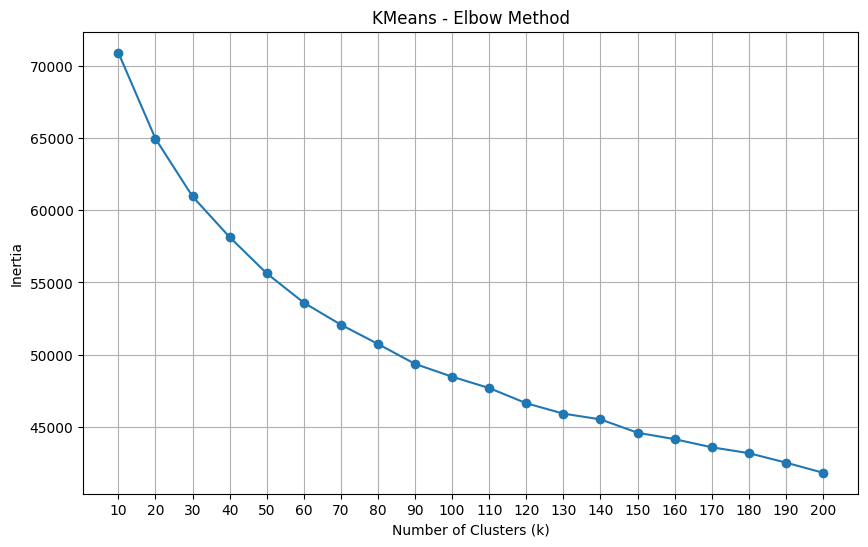

In [61]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('KMeans - Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [62]:
# Apply KMeans
kmeans = KMeans(n_clusters=150, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(reduced)

In [63]:
# Compute the final cosine similarity
cosine_sim = cosine_similarity(reduced)

In [64]:
# Map title to index for quick lookup
title_to_index = pd.Series(df.index, index=df['title'].str.lower()).to_dict()

In [65]:
# Get books recommendation
def recommend_books_hybrid(selected_titles, top_n=10):
    indices = [title_to_index.get(title.lower()) for title in selected_titles if title.lower() in title_to_index]

    if not indices:
        print("None of the selected books were found in the dataset.")
        return pd.DataFrame()

    # Calculate the average similarity score for the input books
    sim_scores = np.mean(cosine_sim[indices], axis=0)

    # Get books from the clusters
    selected_clusters = df.iloc[indices]['cluster'].unique()
    candidate_mask = df['cluster'].isin(selected_clusters)
    candidate_indices = np.where(candidate_mask)[0]
    candidate_indices = [i for i in candidate_indices if i not in indices]
    
    # Create a dataframe of candidate books with their similarity scores
    recommendations = pd.DataFrame({
        'index': candidate_indices,
        'similarity_score': sim_scores[candidate_indices]
    })
    
    # Merge with original dataframe to get rating and numRatings
    recommendations = recommendations.merge(df[['rating', 'numRatings']], left_on='index', right_index=True)
    
    # Normalize popularity (numRatings) using a log transform to handle skew, then scale to 0-1
    recommendations['popularity_score'] = np.log1p(recommendations['numRatings'])
    recommendations['popularity_score'] = recommendations['popularity_score'] / recommendations['popularity_score'].max()
    recommendations['rating_score'] = recommendations['rating'] / 5.0
    
    # Calculate the hybrid score with weights
    # 50% content similarity, 30% rating, 20% popularity
    recommendations['hybrid_score'] = (
        (0.5 * recommendations['similarity_score']) +
        (0.3 * recommendations['rating_score']) +
        (0.2 * recommendations['popularity_score'])
    )
    
    # Sort by the hybrid score
    top_recommendations = recommendations.sort_values(by='hybrid_score', ascending=False).head(top_n)
    
    # Get the final book details
    final_indices = top_recommendations['index']
    final_recs = df.iloc[final_indices][['title', 'author', 'genres', 'rating', 'numRatings','description']].copy()
    final_recs['hybrid_score'] = top_recommendations['hybrid_score'].values
    final_recs['similarity_score'] = top_recommendations['similarity_score'].values
    
    return final_recs

In [66]:
# Trial
test_titles = ["The Hobbit", "Harry Potter and the Philosopher's Stone", "Eragon"]
recommendations = recommend_books_hybrid(test_titles, top_n=10)

print(f"\nRecommendations for: {', '.join(test_titles)}")
print(recommendations)


Recommendations for: The Hobbit, Harry Potter and the Philosopher's Stone, Eragon
                            title                                  author  \
376                      Brisingr  Christopher Paolini (Goodreads Author)   
365                        Eldest  Christopher Paolini (Goodreads Author)   
2436                 Emperor Mage        Tamora Pierce (Goodreads Author)   
611                   Inheritance  Christopher Paolini (Goodreads Author)   
2937                 Wolf-Speaker        Tamora Pierce (Goodreads Author)   
2031       The Hero and the Crown                          Robin McKinley   
1267    Eragon, Eldest & Brisingr  Christopher Paolini (Goodreads Author)   
1654                   Wild Magic        Tamora Pierce (Goodreads Author)   
645          A Wizard of Earthsea                       Ursula K. Le Guin   
7998  The Forgotten Beasts of Eld                    Patricia A. McKillip   

                                                 genres  rating  numR

In [67]:
# Display cluster of genre
cluster_to_genre = {}

for cluster_id in sorted(df['cluster'].unique()):
    cluster_genres = df[df['cluster'] == cluster_id]['genres']
    
    # Combine all genres in the cluster into a single string
    all_genres = ", ".join(cluster_genres).lower().split(",")
    all_genres = [g.strip() for g in all_genres if g.strip()]
    
    # Count the frequency of each genre in the cluster and make it the new name of the cluster
    if all_genres:
        top_genre = pd.Series(all_genres).value_counts().idxmax()
        cluster_to_genre[cluster_id] = top_genre
    else:
        cluster_to_genre[cluster_id] = "unknown"

df['cluster_name'] = df['cluster'].map(cluster_to_genre)

In [68]:
cluster_to_genre

{np.int32(0): "'fiction'",
 np.int32(1): "'coming of age'",
 np.int32(2): "['fantasy'",
 np.int32(3): "'contemporary'",
 np.int32(4): "'roman'",
 np.int32(5): "'fiction'",
 np.int32(6): "'fiction'",
 np.int32(7): "'inspirational'",
 np.int32(8): "'historical'",
 np.int32(9): "'biography'",
 np.int32(10): "'dark'",
 np.int32(11): "['young adult'",
 np.int32(12): "'fiction'",
 np.int32(13): "'spirituality'",
 np.int32(14): "'fiction'",
 np.int32(15): "['romance'",
 np.int32(16): "'paranormal'",
 np.int32(17): "['fantasy'",
 np.int32(18): "'war'",
 np.int32(19): "'fiction'",
 np.int32(20): "'crime'",
 np.int32(21): "'post apocalyptic'",
 np.int32(22): "'school'",
 np.int32(23): "'war'",
 np.int32(24): "'christian'",
 np.int32(25): "'magical realism'",
 np.int32(26): "'literature'",
 np.int32(27): "'romance'",
 np.int32(28): "'fiction'",
 np.int32(29): "'animals'",
 np.int32(30): "'fiction'",
 np.int32(31): "'literature'",
 np.int32(32): "'inspirational'",
 np.int32(33): "'literature'",
 n

In [69]:
# Save model
artifacts = {
    'books_df': df,
    'cosine_sim': cosine_sim,
    'kmeans': kmeans
}

for model, obj in artifacts.items():
    file_path = f'{model}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Saved: {file_path}")


Saved: books_df.pkl
Saved: cosine_sim.pkl
Saved: kmeans.pkl
